# Mult-View

In [1]:
import numpy as np
import tensorflow as tf
import tflearn
from gpu_dashboard.tf_utils import tf_init
from computer_vision.scripts.models import CNN2
from computer_vision.scripts.layers import BranchedLayer, AvgPoolLayer, MergeLayer, LayerModule, MaxPoolLayer, GlobalAvgPoolLayer,\
    FlattenLayer, DropoutLayer, ConvLayer, ResidualLayer

# config = tf_init()

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import os
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = ''
%matplotlib inline

In [3]:
img_height = 128
img_width = 128

target_height = 100
target_width = 100

# y0, x0, height, width
upper_left = [0, 0, target_height, target_width]
upper_right = [0, img_width - target_width, target_height, target_width]
lower_left = [img_height - target_height, 0, target_height, target_width]
lower_right = [img_height - target_height, img_width - target_width, target_height, target_width]
center = [(img_height - target_height) // 2, (img_width - target_width) // 2, target_height, target_width]
boxes = [upper_left, upper_right, lower_left, lower_right, center]

In [4]:
img1 = plt.imread('/afs/csail.mit.edu/u/n/nhunt/00000001.jpg')
img2 = plt.imread('/afs/csail.mit.edu/u/n/nhunt/00000002.jpg')

img_p = tf.placeholder(tf.uint8, (None, 128, 128, 3))
# img_ = tf.image.convert_image_dtype(img_p, tf.float32)
crop_ops = [tf.image.crop_to_bounding_box(img_p, *box) for box in boxes]
crop_ops.extend([tf.map_fn(tf.image.flip_left_right, crop) for crop in crop_ops])

In [7]:
tf.concat(crop_ops, axis=0)

<tf.Tensor 'concat:0' shape=(?, 100, 100, 3) dtype=uint8>

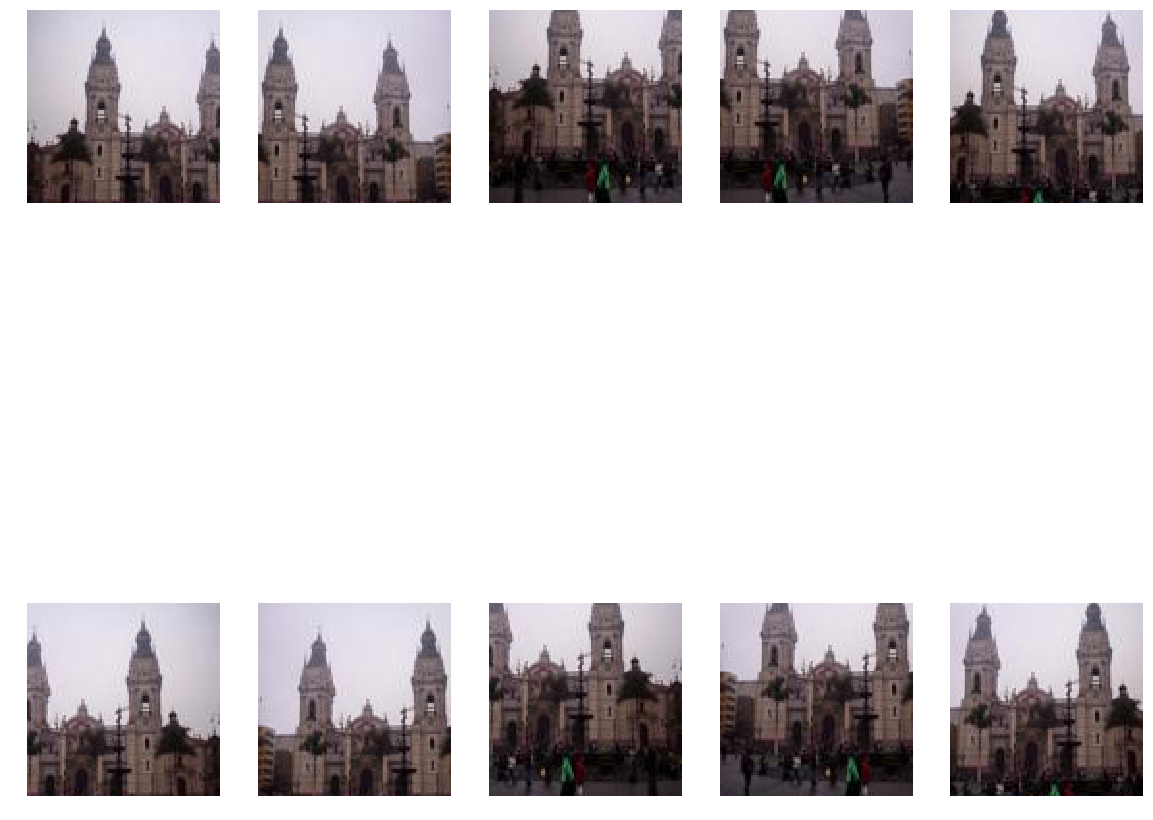

In [28]:
sess = tf.Session()
crops = sess.run(crop_ops, {img_p: [img1]})

plt.figure(figsize=(20, 20))
for i in range(len(crops)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.squeeze(crops[i]))
    plt.axis('off')

# Incep

In [1]:
from argparse import ArgumentParser
import os
import numpy as np
import tensorflow as tf
import tflearn
from computer_vision.scripts.utils import load_data, get_abs_path, tf_init, acc_at_k
import time
from computer_vision.scripts.models import CNN2
from computer_vision.scripts.layers import BranchedLayer, AvgPoolLayer, MergeLayer, LayerModule, MaxPoolLayer, GlobalAvgPoolLayer,\
    FlattenLayer, DropoutLayer, ConvLayer as _ConvLayer
from typing import Union, Sequence, Dict, Optional
_numeric = Union[int, float]
_OneOrMore = lambda type_: Union[type_, Sequence[type_]]

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
class Args():
    pass

args = Args()
args.learning_rate = .001
args.l2_lambda = .0001
args.scaling = False
args.na = 1
args.nb = 1
args.nc = 1
args.batch_norm = True
args.drop_prob = 0.8
args.device = 1

batch_norm = args.batch_norm
config = tf_init(args.device)
aug = 'LR_contrast_.75_hue_.15_rot_4'
model_name = f"inception_aug_{aug}_l2_{args.l2_lambda}_p_{args.drop_prob}_na_{args.na}_nb_{args.nb}_nc_{args.nc}" \
             f"_bn_before_{args.batch_norm}_lr_{args.learning_rate}_e700_bs64_dummy"

def ConvLayer(*args, **kwargs):
    return _ConvLayer(*args, batch_norm=batch_norm, **kwargs)

inception_a = LayerModule([
    BranchedLayer([AvgPoolLayer(1, 1), ConvLayer(96, 1), ConvLayer(64, 1), ConvLayer(64, 1)]),
    BranchedLayer([ConvLayer(96, 1), None, ConvLayer(96, 3), ConvLayer(96, 3)]),
    BranchedLayer([None, None, None, ConvLayer(96, 3)]),
    MergeLayer(axis=3)
])

inception_b = LayerModule([
    BranchedLayer([AvgPoolLayer(1, 1), ConvLayer(384, 1), ConvLayer(192, 1), ConvLayer(192, 1)]),
    BranchedLayer([ConvLayer(128, 1), None, ConvLayer(224, [7, 1]), ConvLayer(192, [1, 7])]),
    BranchedLayer([None, None, ConvLayer(256, [1, 7]), ConvLayer(224, [7, 1])]),
    BranchedLayer([None, None, None, ConvLayer(224, [1, 7])]),
    BranchedLayer([None, None, None, ConvLayer(256, [7, 1])]),
    MergeLayer(axis=3)
])

inception_c = LayerModule([
    BranchedLayer([AvgPoolLayer(1, 1), ConvLayer(256, 1), ConvLayer(384, 1), ConvLayer(384, 1)]),
    BranchedLayer([ConvLayer(256, 1), None, BranchedLayer([ConvLayer(256, [1, 3]), ConvLayer(256, [3, 1])]), ConvLayer(448, [1, 3])]),
    BranchedLayer([None, None, None, ConvLayer(512, [3, 1])]),
    BranchedLayer([None, None, None, BranchedLayer([ConvLayer(256, [3, 1]), ConvLayer(256, [1, 3])])]),
    MergeLayer(axis=3)
])

layers = [
    ConvLayer(32, 3, 2, padding='valid'),
    ConvLayer(32, 3),
    ConvLayer(64, 3),
    # don't use stride of 2 since our images are smaller
    BranchedLayer([MaxPoolLayer(3, padding='valid'), ConvLayer(96, 3, padding='valid')]),
    MergeLayer(axis=3),
    BranchedLayer([ConvLayer(64, 1), ConvLayer(64, 1)]),
    BranchedLayer([ConvLayer(96, 3, padding='valid'), ConvLayer(64, [7, 1])]),
    BranchedLayer([None, ConvLayer(64, [1, 7])]),
    BranchedLayer([None, ConvLayer(96, 3, padding='valid')]),
    MergeLayer(axis=3),
    BranchedLayer([ConvLayer(192, 3, strides=2, padding='valid'), MaxPoolLayer(3, strides=2, padding='valid')]),
    MergeLayer(axis=3),
    *([inception_a] * args.na),  # x4
    ConvLayer(1024, 3, strides=2),  # reduction_a
    *([inception_b] * args.nb),  # x7
    ConvLayer(1536, 3, strides=2),  # reduction_b
    *([inception_c] * args.nc),  # x3
    GlobalAvgPoolLayer(),
    FlattenLayer(),
    DropoutLayer(rate=args.drop_prob)
]

data_params = {'na': args.na, 'nb': args.nb, 'nc': args.nc, 'batch_norm': batch_norm, 'drop_prob': args.drop_prob,
               'augmentation': True}

train_fnames = ['/afs/csail.mit.edu/u/n/nhunt/github/computer_vision/miniplaces/data/train_0.tfrecord']
dev_fnames = ['/afs/csail.mit.edu/u/n/nhunt/github/computer_vision/miniplaces/data/val_0.tfrecord']

In [4]:
cnn = CNN2(layers, n_classes=100, batch_size=64, l2_lambda=args.l2_lambda,
          learning_rate=args.learning_rate, add_scaling=args.scaling, data_params=data_params,
          models_dir=get_abs_path('../miniplaces/models'), config=config,
          img_width=128, img_height=128, augment=2, model_name=model_name)

In [5]:
cnn.train(train_fnames, dev_fnames, train_batches_per_epoch=700, dev_batches_per_epoch=int(10_000 / 128), verbose=1, n_epochs=1)

Train loss: 6.549; Dev loss: 5.721. Metrics: {'acc_default': 0.073918268, 'dev_loss': 5.7205029, 'train_loss': 6.5488377, 'train_time': 6.758027549584707, 'train_complete': False}. Runtime: 7.399540221691131


{'acc_default': 0.073918268,
 'dev_loss': 5.7205029,
 'train_complete': True,
 'train_loss': 6.5488377,
 'train_time': 6.758027549584707}

In [8]:
dev_fnames = ['/afs/csail.mit.edu/u/n/nhunt/github/computer_vision/miniplaces/data/val_0.tfrecord']

In [20]:
import pandas as pd
from computer_vision.scripts.utils import acc_at_k

In [83]:
img_height = 128
img_width = 128

target_height = 100
target_width = 100

# y0, x0, height, width
upper_left = [0, 0, target_height, target_width]
upper_right = [0, img_width - target_width, target_height, target_width]
lower_left = [img_height - target_height, 0, target_height, target_width]
lower_right = [img_height - target_height, img_width - target_width, target_height, target_width]
center = [(img_height - target_height) // 2, (img_width - target_width) // 2, target_height, target_width]
boxes = [upper_left, upper_right, lower_left, lower_right, center]

img_p = tf.placeholder(tf.uint8, (None, 128, 128, 3))
img_ = tf.image.convert_image_dtype(img_p, tf.float32)
crop_ops = [tf.image.crop_to_bounding_box(img_, *box) for box in boxes]
crop_ops.extend([tf.map_fn(tf.image.flip_left_right, crop) for crop in crop_ops])
crop_op = tf.concat(crop_ops, axis=0)

sess = tf.Session()

In [130]:
all_preds = []
all_labels = []
cnn.sess.run(cnn.data_init_op, {cnn.inputs_p['default']: dev_fnames})

while True:
    try:
        # pull the images out before augmentation occurs; get the labels too or else we'll lose them
        imgs, labels = cnn.sess.run(['IteratorGetNext:0', 'IteratorGetNext:1'])

        # do our own augmentation
        cropped_imgs = sess.run(crop_op, {img_p: imgs})

        # feed the images back in just after augmentation
        preds = cnn.sess.run(cnn.predict, {'cond/Merge:0': cropped_imgs})['default']

        # make sure to get the ordering right so you have the proper 10 images together; average their probabilities
        n_imgs = len(preds) // 10
        preds = np.concatenate([preds[i * n_imgs:(i + 1) * n_imgs].reshape(n_imgs, 100, 1) for i in range(10)], axis=2).mean(axis=2)
        all_preds.append(preds)
        all_labels.append(labels)
    except tf.errors.OutOfRangeError:
        pass

KeyboardInterrupt: 

In [ ]:
np.concatenate(all_preds).shape, np.concatenate(all_labels).shape

In [ ]:
labels = np.concatenate(all_labels)

In [ ]:
preds = pd.DataFrame(np.concatenate(all_preds))

In [ ]:
print(acc_at_k(1, preds, labels), acc_at_k(5, preds, labels))

In [31]:
for _ in range(5):
    preds, labels = cnn._batch([cnn.predict['default'], cnn.labels_p['default']], inputs={'default': dev_fnames}, dataset=True)

    labels = np.concatenate(labels)
    preds = pd.DataFrame(np.concatenate(preds))
    print(acc_at_k(1, preds, labels), acc_at_k(5, preds, labels))

0.083 0.2643
0.0806 0.2664
0.0823 0.268
0.0839 0.266
0.0841 0.2662


In [26]:
acc_at_k(1, pd.DataFrame(preds), labels)

0.084599999999999995

In [24]:
acc_at_k(1, pd.DataFrame(preds), labels)

0.083799999999999999

In [32]:
1 - 0.7309, 1 - 0.4283

(0.2691, 0.5717)